# Assignment 2: Elasticsearch and Text Mining

Due: Monday, December 12, 2022, at 2pm via Moodle

**Team Members**
- Kushal Gaywala, kushal.gaywala@stud.uni-heidelberg.de
- Rishabh Tiwari, rishabh.tiwari@stud.uni-heidelberg.de
- Jakob Forstmann, jakob.forstmann@stud.uni-heidelberg.de
- Jonathan Alexander Hirsch, ww251@stud.uni-heidelberg.de

### Submission Guidelines

- Solutions need to be uploaded as a single Jupyter notebook. You will find this notebook contains some pre-filled cells that you should complete for the individual tasks.
- For answers requiring written solutions, use Markdown cells (in combination with Jupyter LaTeX support) **inside this notebook**. Do *not* hand in any separate files, simply re-upload the `.ipynb` file.
- Download the .zip file containing the dataset but do *not* upload it with your solution.
- Make sure that the names of all team members are present in the solution.

In [1]:
%%bash
. ~/.bashrc
python3 -m pip install -r requirements.txt
# Install necessary packages


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
%%bash
./ ~/.bashrc
python3 -m spacy download en_core_web_sm
# Install required language model for spaCy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 11.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


bash: Zeile 1: ./: Ist ein Verzeichnis

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip



## Question 2-1: "The Simpsons" Dataset (1 + 4 + 3 + 2 + 6 + 5 = 21 points)

"The Simpsons" is the world’s longest-running animated sitcom. The show revolves around the lives of the Simpson family, which consists of Homer, Marge, Bart, Lisa, and the little Maggi.
For this exercise, you will work with the dataset that contains characters, locations, episode details, and script lines for approximately 600 Simpsons episodes, dating back to 1989.
We will explore the data and use visualizations to gain some insight into the show. The Zip file alongside this notebook should contain the following files:

` simpsons_characters.csv, simpsons_locations.csv, simpsons_script_lines.csv, simpsons_episodes.csv`

Take some time and familiarize yourself with the data. `simpsons_characters.csv` contains the character-names and their gender.
`simpsons_locations.csv` contains information about locations in the shows, and `simpsons_episodes.csv` has information about each episode including their title, rating, and views.
Finally, `simpsons_script_lines.csv` lists all the lines in the show, who said the line and where it was said. Be aware that this data set is not cleaned and, hence, includes faulty data as well as inconsistent data types.

In [3]:
# General imports
import os

import pandas as pd
import numpy as np
import spacy
import matplotlib
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from collections import Counter 

# Ensure matplotlib works correctly with Jupyter
%matplotlib inline

### 1. Data Loading (1 point)
Load the four datasets in the respective variables using pandas, and make sure to set the type of the `character_id` to integer.

In [4]:
df_characters = pd.read_csv("data/simpsons_characters.csv")
df_locations =pd.read_csv("data/simpsons_locations.csv")
df_script = pd.read_csv("data/simpsons_script_lines.csv",dtype={"character_id":pd.Int64Dtype()},na_values="guess what i also play frankenstein")
df_episodes = pd.read_csv("data/simpsons_episodes.csv")


/home/jonathan/Dokumente/Data_and_Computer_Science_HD/DSTA/Assignments/DataScience-Assignments-WS-2022-23/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Drop all lines associated with the (non-numeric) character ID `142024`.

In [5]:
### Your code
print(df_script.iloc[142022:142028]["character_id"])
## I think the task states to drop the line 142024 but I am not sure what the instructor wrote on discord 
df2 = df_script.drop([142024])

142022     146
142023     857
142024    <NA>
142025     146
142026    1078
142027    <NA>
Name: character_id, dtype: Int64


Next, use panda's `.head()` function to inspect the top rows of each dataframe.

In [6]:
print(df_script.head(2))
print("="*40)
print(df_characters.head(2))
print("="*40)
print(df_episodes.head(2))
print("="*40)
print(df_locations.head(2))

     id  episode_id  number  \
0  9549          32     209   
1  9550          32     210   

                                            raw_text timestamp_in_ms  \
0  Miss Hoover: No, actually, it was a little of ...          848000   
1  Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?          856000   

  speaking_line  character_id  location_id raw_character_text  \
0          True           464          3.0        Miss Hoover   
1          True             9          3.0       Lisa Simpson   

               raw_location_text  \
0  Springfield Elementary School   
1  Springfield Elementary School   

                                        spoken_words  \
0  No, actually, it was a little of both. Sometim...   
1                             Where's Mr. Bergstrom?   

                                     normalized_text word_count  
0  no actually it was a little of both sometimes ...         31  
1                                wheres mr bergstrom          3  
   id            

### 2. Prominent Characters (4 points)

Let us now take a look at the most important characters of the show. To start, retrieve the most prominent characters by the number of spoken words/lines throughout the show. 

Extract the top 10 characters based on the number of spoken words (word count), as well as the 10 most prominent characters regarding their sum total number of lines.

You might notice that there is a column with `word_count` in the `df_scripts` data frame, but cleaning it up might be tricky. To find the sum of all values, first remove the `nan` entries and any other string characters in that column. You can use the provided `conv` function for this.

In [7]:
def conv(row):
    try:
        return int(row)
    except:
        return np.nan
# First apply the conv() filtering on the word count
df_script["word_count"] = df_script["word_count"].apply(conv)

# And then drop all `nan` values in "word_count"
# Hint: Make sure the operation is done in-place.
df_script.dropna(subset=["word_count"],inplace=True)

In [8]:
# Now aggregate the top characters by words:
top_characters_by_words = df_script.groupby("character_id").agg(
    {"word_count": "sum", "raw_character_text": "first"}).sort_values(by=["word_count"], ascending=False)

# And do the same by lines:
top_characters_by_lines = df_script.groupby("character_id").agg(
    {"spoken_words": "count", "raw_character_text": "first"}).sort_values(by=["spoken_words"],ascending=False)


Compare both results by drawing two bar plots: For the first plot, the x-axis should show the name of the top 10 characters with regard to the word count and the y-axis should display the number of spoken words.

In the second plot, you should do the same, but this time considering the number of lines(not words) for each character. Note that the characters shown in the two plots might differ.


<AxesSubplot:ylabel='number of words spoken'>

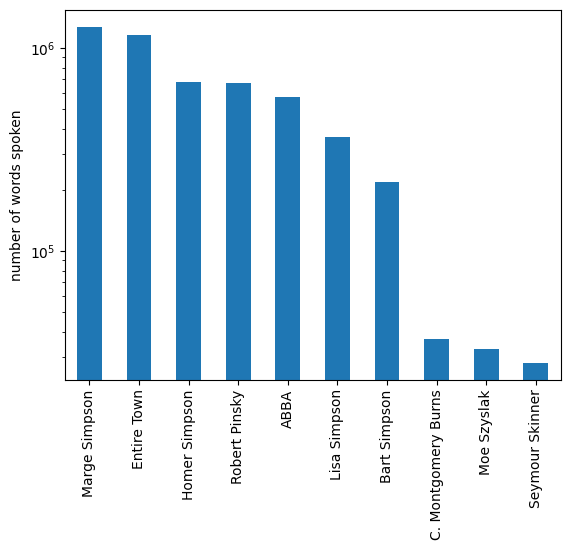

In [9]:
# First plot: Top 10 characters by word count
# Hint: Try to use the integration of matplotlib and pandas to directly plot from a dataframe.

top_10_characters_by_words = top_characters_by_words.head(10)

top_10_characters_by_words.plot(
    x="raw_character_text",
    logy=True,kind="bar",
    xlabel="",
    ylabel="number of words spoken",
    legend=False
)

<AxesSubplot:ylabel='number of lines'>

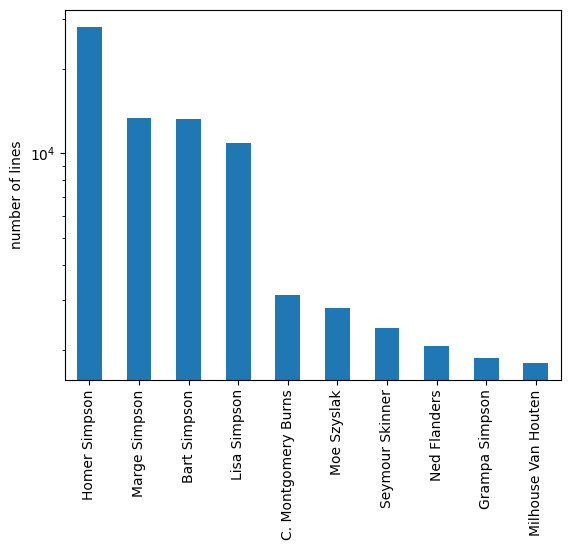

In [10]:
# Second plot: Top 10 characters by lines
top_10_characters_by_lines = top_characters_by_lines.head(10)
top_10_characters_by_lines.plot(
    x="raw_character_text",
    logy=True,
    kind="bar",
    xlabel="",
    ylabel="number of lines",
    legend=False
)

Compare the results of the two plots: What do you notice? Do the results look correct to you?

### answer: 
-  Homer Simpsons tends to have shorter lines than Marge Simpsons since he has more lines but fewer words than her 
-  the entire town speaks more words than the individual members of the simpson family except for Marge Simpson but has 
   significantly less lines than each member of simpson family. This makes sense considering that the entire town is not
   a main character thus they should not have many lines through the series
-  Suprisingly the entire town does have a speaking line they have the second longest lines since they have the the second-largest word count but 
   they are'nt among the top ten regarding the line count. This seems strange to us since we would expect the entire town ro rather have shorter lines 
   like "Hello how are you" 
-  as expected the four main characters have the most lines and but are suprisingly only in the top 6 of overall spoken words 

### 3. Common Words (3 points)

We continue by examining the dialogues in more detail, by looking at the top 20 most commonly appearing words (tokens).

To generate a meaningful output, use the following pre-processing pipeline, parts of which were explained in more detail during the tutorials and the lecture:
- Use spaCy (`en_core_web_sm`) to process all text.
- Instead of considering the raw text, use the lemmatized token provided by spaCy.
- Additionally, ignore any token that is classified as punctuation by spaCy.
- Also skip any token which is classified as a stop word by spaCy.

In [11]:
from collections import Counter 
# Load the spacy model specified above. Make sure to disable the "ner" component for more speed. 
nlp = spacy.load("en_core_web_sm")
nlp.disable_pipes("ner")
word_list =[]
docs = nlp.pipe(df_script["spoken_words"])
for doc in docs:
    for token in doc:
        if not token.is_stop and not token.is_punct:
                    token = token.lemma_
                    word_list.append(token)

word_counter = Counter(word_list)
counter = word_counter.most_common(20)
print(counter)

[('oh', 8466), ('like', 6260), ('go', 5463), ('know', 5455), ('get', 4905), ('hey', 4297), ('right', 4112), ('think', 4108), ('come', 4069), ('look', 3715), ('good', 3623), ('want', 3572), ('Bart', 3547), ('Homer', 3499), ('to', 3483), ('let', 3263), ('uh', 3066), ('yeah', 2978), ('time', 2749), ('man', 2640)]


Now plot a graph with the top 20 words on the x-axis and their respective frequencies on the y-axis, similar to the previous question.

<AxesSubplot:xlabel='word'>

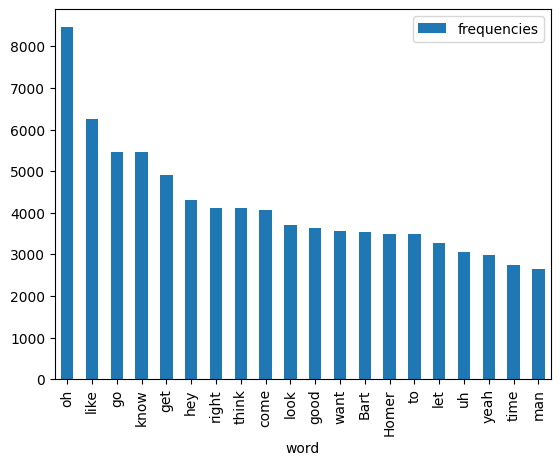

In [12]:
# Provide a plot of the frequencies of the most common 20 words.

top_20_frequencies = pd.DataFrame(counter,columns=["word","frequencies"])
top_20_frequencies.plot(x="word",y="frequencies",kind="bar")

### 4. Named Entity Wordcloud (2 points)

Apply named entity recognition (NER) using SpaCy and generate a word cloud of the most commonly appearing 50
named entities that have the type `PERSON`. Visualize the resulting entities in a word cloud.
Take into account that you cannot simply use the 
output of the previous task, since NER was explicitly disabled.
 Since the named entity recognition takes quite some time, use only the first `10000` scripts.

In [13]:
# Load the English spacy model again, but this time do not disable the NER module.
nlp =spacy.load("en_core_web_sm")
named_entities = []

# Extract named entities of the type "PERSON" from each script.
for script in df_script.spoken_words.tolist()[:10000]:
    doc = nlp(script)
    for entity in doc.ents:
        if entity.label_ =="PERSON":
            named_entities.append(entity.text)

top_50_named_entites = dict(Counter(named_entities).most_common(50))

To visualize the word cloud, you may use the `wordcloud` package, which works in combination with `matplotlib`. Make sure to limit the number of visible words to 50, and the maximum font size to 60.

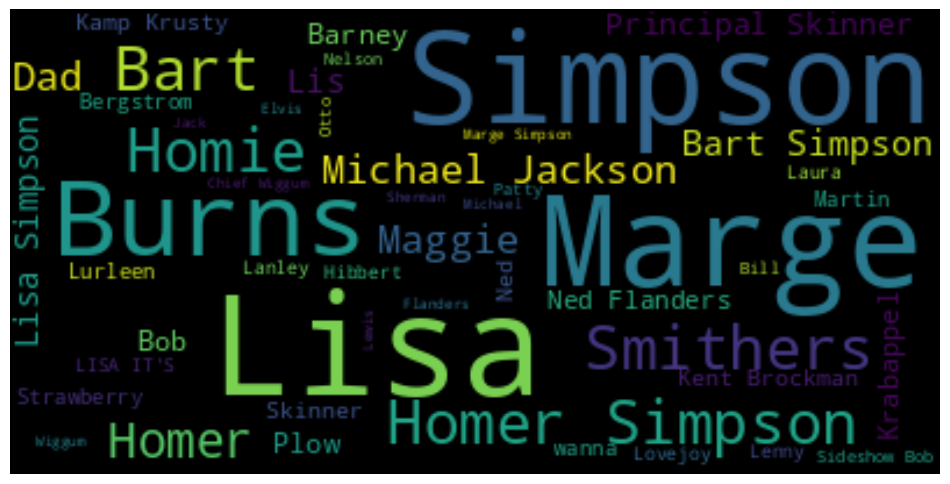

In [14]:
# Create matplotlib skeleton for word cloud figure
fig = plt.figure(1, figsize=(12,12))
plt.axis("off")
cloud = WordCloud(max_font_size=60,max_words=50).fit_words(top_50_named_entites)
plt.imshow(cloud, interpolation="bilinear")

### 5. Normalized Word Importance with TF-IDF (6 points)

The top words so far seem not too informative. We wish to find out the importance of particular words for specific characters, by looking at normalized frequency counts.
As an example, we expect the younger Simpson family members to exhibit a disproportionate frequency for the word "mom" or "dad", compared to other characters.

We looked at the normalization through Term Frequency - Inverse Document Frequency (TF-IDF) in the lecture, which we will use here to investigate lines by `Lisa Simpson` and `Bart Simpson`.

In this case, each script line is a document for a certain character who spoke the words.
Use `CountVectorizer` and `TfidfTransformers` from the `scikit-learn` library. In addition, filter out stop words and words with a frequency of less than 5 occurrences from the analysis. Then plot the TF-IDF values for the top 10 words for Lisa and Bart as bar plots.

In [15]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

script_lines_by_Lisa_Simpson = df_script[df_script["raw_character_text"]=="Lisa Simpson"]["spoken_words"]
script_lines_by_Bart_Simpson = df_script[df_script["raw_character_text"]=="Bart Simpson"]["spoken_words"]
script_lines_concat = pd.concat([script_lines_by_Lisa_Simpson, script_lines_by_Bart_Simpson])

count_vector = CountVectorizer(analyzer="word",stop_words="english",min_df=5) 
term_document_matrix = count_vector.fit_transform(script_lines_concat)
tf_idf_transformer = TfidfTransformer()
tf_idf_values = tf_idf_transformer.fit_transform(term_document_matrix)
names = count_vector.get_feature_names_out()
dense = tf_idf_values.todense()
tf_idf_df = pd.DataFrame(dense,columns=names)

top_10_tf_idf_values = tf_idf_df.sum(axis=0).nlargest(10)

<AxesSubplot:>

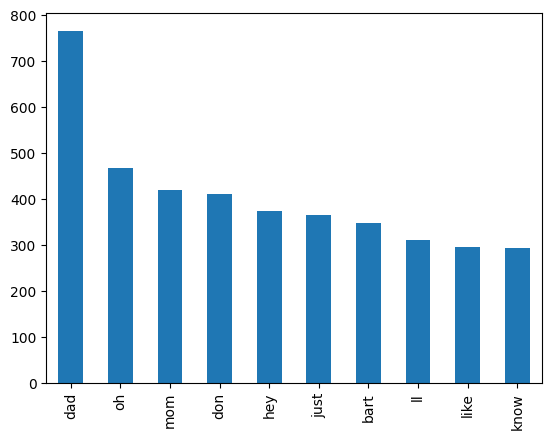

In [16]:
# Plot the top 10 occurrences, weighted by TF-IDF.
top_10_tf_idf_values.plot(kind="bar")

Do your results look correct?

- as already stated in the task it makes sense that "mom" or "dad" are in the top 10 words for Bart and Lisa Simpson 
- It absolutely makes sense that "hey" and "oh" are in the top 10 words because they are very common words 
- however the apperance of "dont" in the top 10 indicates that the used tokenizer split the word "dont`t" in two tokens. In the context of word importance 
  this doesn´t make any sense since "don" alone is not a valid word

By using `CountVectorizer` over the concatenation of all character-specific lines, we can then also compute a (non-normalized) document similarity between the lines of Lisa and Bart. Use cosine similarity over the two document vectors to compare the similarity.

For the `CountVectorizer`, use the same arguments as before (minimum 5 occurrences and no stop words).

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

# script_lines_Lisa_Simpsons is a series
lines_by_Lisa_Simpson = "".join(script_lines_by_Lisa_Simpson.values)
lines_by_Bart_Simpson = "".join(script_lines_by_Bart_Simpson.values)

count_vector = CountVectorizer(analyzer="word",stop_words="english")

matrix_Bart_and_Lisa_Simpson = count_vector.fit_transform([lines_by_Bart_Simpson,lines_by_Lisa_Simpson])

vector_Lisa_Simpson = matrix_Bart_and_Lisa_Simpson[1]
vector_Bart_Simpson = matrix_Bart_and_Lisa_Simpson[0]
similarity = cosine_similarity(vector_Bart_Simpson,vector_Lisa_Simpson)
print(f"cosine similarity between Lisa and Bart Simpsons entire words: {similarity.squeeze():.2f}")

cosine similarity between Lisa and Bart Simpsons entire words: 0.88


### 6. NNMF Topics (5 points)

Uncover interesting topics by using non-negative matrix factorization (NNMF or NMF).

Use the `NMF` implementation from `sklearn` to detect the topics in the scripts, and use text cleaning steps similar to the first task. However, this time perform no lemmatization:
- Use spaCy (`en_core_web_sm`) to process all text.
- Additionally, ignore any token that is classified as punctuation by spaCy.
- Also skip any token which is classified as a stop word by spaCy.

Set the `max_features` of `CountVectorizer` to 10,000 and `random_state` of the `NMF` to 42, and `n_components=10`.

In [18]:
from sklearn.decomposition import NMF

In [19]:
# Clean the documents according to the specifications
class Tokenizer():
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm")
        self.nlp.disable_pipes("ner")

    def __call__(self,doc):
        doc = self.nlp(doc)
        return [token.text for token in doc if not token.is_stop and not token.is_punct]

In [20]:
# Apply the NNMF method as specified above
count_vector = CountVectorizer(tokenizer=Tokenizer(),max_features=10000,analyzer="word")
document_term_matrix = count_vector.fit_transform(df_script["spoken_words"].values)

In [21]:
# document_term_matrix: rows = documents, columns word 
Simpson_NMF = NMF(n_components=10,random_state=42)
# use components to get themes as rows and  words as columns
document_topic_matrix = Simpson_NMF.fit_transform(document_term_matrix)
term_topic_matrix = Simpson_NMF.components_

## compute L1 Norm of topic_word_matrix
x = document_topic_matrix.sum(axis=0)
y = term_topic_matrix.sum(axis=1)

z = np.argsort(x*y)[:-3:-1]
components = term_topic_matrix[z]

/home/jonathan/Dokumente/Data_and_Computer_Science_HD/DSTA/Assignments/DataScience-Assignments-WS-2022-23/venv/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


In [22]:
def show_topics(components,num_top_words,vocab):
    #for each component or topic sorts the row values from large to small and 
    # returns the top words as the representation of the topic.
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in components])
    return [' '.join(t) for t in topic_words]

Use the `show_topics` method to show the top-20 words for the top 2 topics.

In [23]:
lines_to_print = show_topics(components,20,count_vector.get_feature_names_out())
for line in lines_to_print:
    print(line)
    print()

right let yeah uh okay time good want come little marge thing think way tell huh going yes sure boy

know want think little dad marge uh good people man time thing look love maybe come need lisa things lot



## Question 2-2: Boosting results in Elasticsearch (1 + 9 + 2 = 12 points)

Before you start, make sure to download the file `test_data.json`, available on [Moodle](https://moodle.uni-heidelberg.de/pluginfile.php/1006481/mod_label/intro/test-data.json). This question assumes you have a running installation of Elasticsearch 7.X on your machine. If not, make sure to follow the steps detailed in the first tutorial to set up an instance. To complete the following questions, you will have to adjust the given URLs with your own settings. Look out for mentions of `<login>`, `<password>` and `<port>` and replace them accordingly.

Bulk load the content of `test_data.json` into an index called `dishes`. You may use the following shell command:

```bash
curl -u <login>:<password> -H "Content-Type:application/x-ndjson" -XPOST http://localhost:<port>/dishes/_bulk --data-binary "@test_data.json"
```
1. Provide a command to extract the dynamic mapping that is created in this scenario. Make sure that the output mapping is included in your solution (potentially pasting it into another cell or execute through the ).

2. Write queries to the `dishes` index given the specified criteria. The matching documents should be included in your solution, including their respective scores.

a) Return all dishes that have a preparation time of less than 15 minutes

b) All dishes that contain `spaghetti` in the title.

c) All dishes that received at least one 5-star rating and were created after 2016.

d) Dishes that serve between 6 to 8 people.

e) Dishes that mention both of the phrases "pasta" and "parmigiano" in the instructions.

f) All recipes that require more than 10 ingredients

g) Extend your query from b), such that it searches for `spaghetti` in both the title *and* description field. Occurrences in the title field should be boosted by a factor of 3.

3. The default analyzer might not be perfect for working with recipe data. Provide the definition of a custom analyzer which adheres to the following specifications:
   
   - It performs *no* stop word filtering.
   - It applies stemming to all tokens.
   - It does *not* lowercase tokens, but keeps the original case of letters.

## Question 2-3: Document Representations (2 + 2 + 3 = 7 points)

Please fill out the answers directly in the provided fields.

#### a) Why is it preferable to use cosine distance over Euclidean distance when computing document similarity?

Answer: The meaning of the documents is represented by the directions of the corresponding vectors only,
their norm is unimportant,
but the Euclidean distance between two vectors might be very large
although they point in the same or a similar direction.
(Of course, one can also normalize the vectors,
but in this case, the cosine is simply the usual scaler product (i.e. the sum of the product of their components)
so it is way more easy to compute than the Euclidean distance, containing a square root.)

#### b) Identify two shortcomings of Bag-of-Word-based document representations

Answer: One shortcoming is that the order of the words is ignored since only the number of occurences of each word of the vocabulary is counted, so "The blue car is faster than the yellow one." and "The yellow car is faster than the blue one." have the same representation in all approaches based on the Bag-of-Words although they have contrary meanings.

Usually, only a small portion of the entire vocabulary is used in each document.
Therefore, another problem is the high dimension of the usually sparse vectors representing the documents:
The tools known from linear algebra such as scalar product don't have a meaning on this vectors.
This can be solved with some kind of Latent Semantic Analysis such as singular value decomposition (SVD) or non-negativ matrix factorization (NNMF) of the document-term-matrix, producing more interpretable document representations.

#### c) Find the singular value decomposition of the following matrix:

$A = \left[ \begin{matrix}1&-1\\ -2&2\\ 2&-2\end{matrix} \right]$.

Answer:

The singular value decompostion of $A$ is a decompostion $A = Q \Sigma P^T$ with $Q$ as a $3 \times 2$-matrix with $Q^T Q = I_2$, $P$ as a $2 \times 2$-matrix with $P^T P = I_2$ and $\Sigma$ as a non-negative diagonal $2 \times 2$-matrix.
Its diagonal values are called singular values $\sigma_i$.

The singular values of $A$ are the square roots of the eigenvalues of $A^T A$:

$$A^T A = \left[ \begin{matrix} 1 & -2 & 2 \\ -1 & 2 & -2 \end{matrix} \right] \cdot \left[ \begin{matrix}1&-1\\ -2&2\\ 2&-2\end{matrix} \right] = \left[ \begin{matrix} 9 & -9 \\ -9 & 9 \end{matrix} \right] $$

$$\implies CP_{A^T A} (\lambda) = (\lambda - 9)^2 - (+9)^2 = \lambda^2 - 18 \lambda = (\lambda - 18) \cdot \lambda$$

$$\implies Spec(A^T A) = \{0, 18 \} \implies \sigma_1 = \sqrt{18} = 3 \sqrt{2}, \, \sigma_2 = 0$$

$$\implies \Sigma = \left[ \begin{matrix} 3 \sqrt2 & 0 \\ 0 & 0 \end{matrix} \right]$$

The unit eigenvectors of $A^T A$ are the columns of $P$. They can be choosen as $\frac{1}{\sqrt2} \left[ \begin{matrix} 1 \\ -1 \end{matrix} \right]$ for the eigenvalue 18 (singular value $3 \sqrt2$) and as $\frac{1}{\sqrt2} \left[ \begin{matrix} 1 \\ 1 \end{matrix} \right]$ for the eigenvalue 0 (singular value 0):

$$P = \frac{1}{\sqrt2} \left[ \begin{matrix} 1 & 1 \\ -1 & 1 \end{matrix} \right]
\implies P^T = \frac{1}{\sqrt2} \left[ \begin{matrix} 1 & -1 \\ 1 & 1 \end{matrix} \right]$$

Since the colums of $P$ are unit eigenvectors of a symmetric matix ($A^T A$),
$P^T P = I_2$ is fullfilled.

The columns $Q_i$ of $U$ corresponding nonzero singular values $\sigma_i$ are $\frac{1}{\sigma_i} A P_i$,
so here:

$$Q_1 = \frac{1}{3 \sqrt2} \cdot \left[ \begin{matrix}1&-1\\ -2&2\\ 2&-2\end{matrix} \right] \cdot \frac{1}{\sqrt2} \left[ \begin{matrix} 1 \\ -1 \end{matrix} \right] = \frac16 \left[ \begin{matrix} 2 \\ -4 \\ 4  \end{matrix}\right] = \left[ \begin{matrix} \frac13 \\ -\frac23 \\ \frac23 \end{matrix} \right]$$

Since $Q$ will be multiplied with $\Sigma$ from the left and the last row of $\Sigma$ is zero,
the second column of $Q$ is actually unimportant.
Due to the constraint $Q^T Q = I_2$ it shall be orthogonal to $Q_1$ and normalized.
Such a vector is

$$Q_2 = \left[ \begin{matrix} 0 \\ \frac{\sqrt2}{2} \\ \frac{\sqrt2}{2} \end{matrix} \right]$$

so

$$Q = \left[ \begin{matrix} \frac13 & 0 \\ -\frac23 & \frac{\sqrt2}{2} \\ \frac23 & \frac{\sqrt2}{2} \end{matrix} \right].$$